In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from multitask_sparse_parity import generate_multitask_sparse_parity_dataset
from sgld_utils import (
    SGLDConfig, 
    run_sgld
)
from utils import to_json_friendly_tree, running_mean


In [2]:
import jax
import jax.numpy as jnp
import equinox as eqx
from typing import Sequence, Callable, Dict
import optax


class MLP(eqx.Module):
    layers: Sequence[eqx.nn.Linear]
    activation: Callable = eqx.static_field()

    def __init__(
        self,
        in_size: int,
        hidden_sizes: Sequence[int],
        out_size: int,
        key: jax.random.PRNGKey
    ):
        keys = jax.random.split(key, len(hidden_sizes) + 1)
        layers = []
        sizes = [in_size] + list(hidden_sizes) + [out_size]
        for in_size, out_size, key in zip(sizes[:-1], sizes[1:], keys):
            layers.append(eqx.nn.Linear(in_size, out_size, key=key))
        self.layers = layers
        self.activation = jax.nn.relu

    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)


@eqx.filter_value_and_grad
def loss_fn(
    model: MLP,
    x: jnp.ndarray,
    y: jnp.ndarray
) -> jnp.ndarray:
    pred = jax.vmap(model)(x)
    return jnp.mean(optax.sigmoid_binary_cross_entropy(pred, y))

@eqx.filter_jit
def make_step(
    model: MLP,
    x: jnp.ndarray,
    y: jnp.ndarray,
    opt_state,
    optimizer
):
    loss, grads = loss_fn(model, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

@eqx.filter_jit
def compute_accuracy(
    model: MLP,
    x: jnp.ndarray,
    y: jnp.ndarray
) -> float:
    preds = jax.nn.sigmoid(jax.vmap(model)(x)) > 0.5
    return jnp.mean(preds == y)


# @eqx.filter_jit
def compute_task_losses(
    model: MLP,
    features: jnp.ndarray,
    labels: jnp.ndarray,
    n_tasks: int
) -> Dict[int, float]:
    task_losses = {}
    task_errors = {}
    
    for task_idx in range(n_tasks):
        task_mask = features[:, task_idx] == 1
        task_features = features[task_mask]
        task_labels = labels[task_mask]
        loss, _ = loss_fn(model, task_features, task_labels)
        error = 1 - compute_accuracy(model, task_features, task_labels)
        task_losses[task_idx] = float(loss)
        task_errors[task_idx] = float(error)

    
    return task_losses, task_errors

def data_generator(
    features: jnp.ndarray,
    labels: jnp.ndarray,
    batch_size: int,
    key: jax.random.PRNGKey
):
    dataset_size = len(features)
    indices = jnp.arange(dataset_size)
    
    while True:
        key, subkey = jax.random.split(key)
        permuted_indices = jax.random.permutation(subkey, indices)
        
        for start in range(0, dataset_size, batch_size):
            end = min(start + batch_size, dataset_size)
            batch_indices = permuted_indices[start:end]
            yield features[batch_indices], labels[batch_indices]


In [3]:
# config
rngseed = 0
n_tasks, n, k = 30, 50, 3
num_train_samples = 100000
num_test_samples = 50000
alpha = 0.4

hidden_sizes = [256, 256]
batch_size = 256
num_steps = 250001
learning_rate = 1e-3

sgld_config = {
    'epsilon': 1e-7,
    'gamma': 1.0,
    'num_steps': 500,
    "num_chains": 1, 
    "batch_size": 256
}
sgld_config = SGLDConfig(**sgld_config)
loss_trace_minibatch = True
burn_in_prop = 0.9
itemp = 1.0 / jnp.log(num_train_samples)



do_llc_estimation = False
logging_period = 500

# Generate dataset
rng_key = jax.random.PRNGKey(rngseed)
data_key, model_key, split_key, gen_key = jax.random.split(rng_key, 4)
num_total_samples = num_train_samples + num_test_samples

features, labels, subtasks = generate_multitask_sparse_parity_dataset(
    data_key,
    n_tasks,
    n,
    k,
    num_total_samples, 
    alpha=alpha
)
labels = labels.reshape(-1, 1)

# Split into train and test sets
indices = jnp.arange(num_total_samples)
train_indices = jax.random.choice(split_key, indices, shape=(num_train_samples,), replace=False)
test_indices = jnp.setdiff1d(indices, train_indices)

train_features, train_labels = features[train_indices], labels[train_indices]
test_features, test_labels = features[test_indices], labels[test_indices]

# Create model
input_size = n_tasks + n
output_size = 1
model = MLP(input_size, hidden_sizes, output_size, model_key)

# Training setup

optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

# Create data generator
train_gen = data_generator(train_features, train_labels, batch_size, gen_key)

# Training loop
rec = []
for step in range(num_steps):
    x_batch, y_batch = next(train_gen)
    loss, model, opt_state = make_step(model, x_batch, y_batch, opt_state, optimizer)
    
    if step % logging_period == 0:
        test_acc = compute_accuracy(model, test_features, test_labels)
        test_loss, _ = loss_fn(model, test_features, test_labels)
        batch_acc = compute_accuracy(model, x_batch, y_batch)
        print(f"Step {step:6d}, Loss: {loss:.5f}, Test Acc: {test_acc:.7f}")
        
        
        # Compute task-wise test losses
        task_losses, task_errors = compute_task_losses(model, test_features, test_labels, n_tasks)

        # do_llc_estimation
        if do_llc_estimation:
            rngkey, subkey = jax.random.split(rngkey)
            y_realisable = model(train_features)
            y = y_realisable

            rngkey, subkey = jax.random.split(rngkey)
            loss_trace, distances, acceptance_probs = run_sgld(
                subkey, 
                loss_fn, 
                sgld_config, 
                trained_param, 
                x_train, 
                y,
                itemp=itemp, 
                trace_batch_loss=loss_trace_minibatch, 
                compute_distance=False, 
                verbose=False, 
                compute_mala_acceptance=False
            )
            trace_start = min(int(burn_in_prop * len(loss_trace)), len(loss_trace) - 1)
            init_loss = loss_fn(trained_param, x_train, y)
            lambdahat = float(np.mean(loss_trace[trace_start:]) - init_loss) * num_training_data * itemp
            rec.update(
                {
                    "llc_est": float(lambdahat),
                    "loss_trace": loss_trace, 
                    "init_loss": float(init_loss),
                }
            )

            pass
        
        rec.append({
            "step": step,
            "loss": float(loss),
            "test_loss": float(test_loss),
            "test_acc": float(test_acc),
            "batch_acc": float(batch_acc),
            "task_losses": task_losses,
            "task_errors": task_errors
        })


Step      0, Loss: 0.69345, Test Acc: 0.5022400
Step    500, Loss: 0.49874, Test Acc: 0.6990600
Step   1000, Loss: 0.41033, Test Acc: 0.7011600
Step   1500, Loss: 0.40570, Test Acc: 0.7115600
Step   2000, Loss: 0.36085, Test Acc: 0.7429600
Step   2500, Loss: 0.29754, Test Acc: 0.7777600
Step   3000, Loss: 0.30223, Test Acc: 0.7809400
Step   3500, Loss: 0.32249, Test Acc: 0.7813200
Step   4000, Loss: 0.28232, Test Acc: 0.7851400
Step   4500, Loss: 0.27983, Test Acc: 0.7973800
Step   5000, Loss: 0.26672, Test Acc: 0.8143800
Step   5500, Loss: 0.20399, Test Acc: 0.8214000
Step   6000, Loss: 0.13394, Test Acc: 0.8344400
Step   6500, Loss: 0.12993, Test Acc: 0.8444000
Step   7000, Loss: 0.16916, Test Acc: 0.8484200
Step   7500, Loss: 0.12704, Test Acc: 0.8534999
Step   8000, Loss: 0.13743, Test Acc: 0.8540400
Step   8500, Loss: 0.11164, Test Acc: 0.8544800
Step   9000, Loss: 0.08126, Test Acc: 0.8569800
Step   9500, Loss: 0.12576, Test Acc: 0.8582800
Step  10000, Loss: 0.08965, Test Acc: 0.

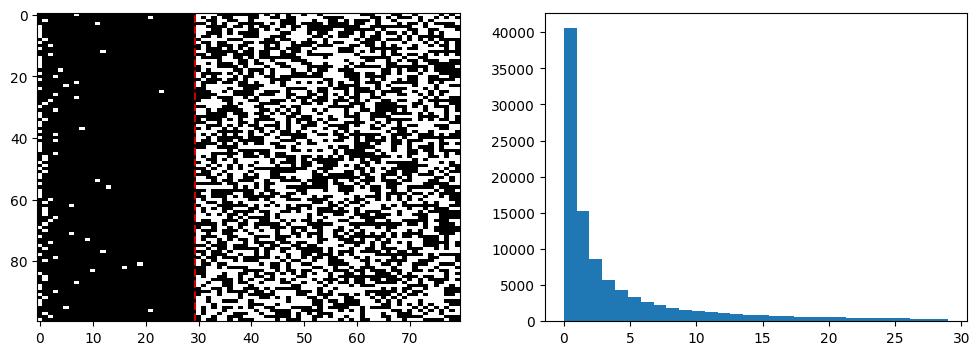

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = axes[0]
ax.imshow(train_features[:100], aspect="auto", cmap="gray");
ymin, ymax = ax.get_ylim()
ax.vlines(n_tasks - 0.6, ymin, ymax, color="r", linestyle="--", alpha=0.8)

ax = axes[1]
ax.hist(jnp.argmax(train_features[:, :n_tasks], axis=1), bins=n_tasks);


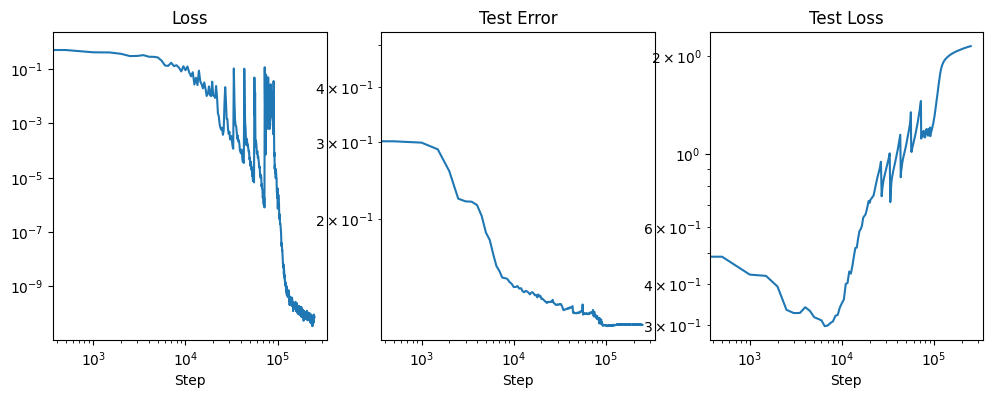

In [5]:
df_rec = pd.DataFrame(rec)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes[0]
ax.plot(df_rec["step"], df_rec["loss"])
ax.set_title("Loss")
ax.set_yscale("log")
ax.set_xscale("log")


ax = axes[1]
ax.plot(df_rec["step"], 1 - df_rec["test_acc"], label="Test Error")
# ax.set_ylim(df_rec["test_acc"].min(), 1)
ax.set_title("Test Error")
ax.set_yscale("log")
ax.set_xscale("log")



ax = axes[2]
ax.plot(df_rec["step"], df_rec["test_loss"], label="Test Loss")
ax.set_title("Test Loss")
ax.set_yscale("log")
ax.set_xscale("log")



for ax in axes:
    ax.set_xlabel("Step")
    # ax.set_yscale("log")
    # ax.set_xscale("log")


<Axes: xlabel='step', ylabel='loss'>

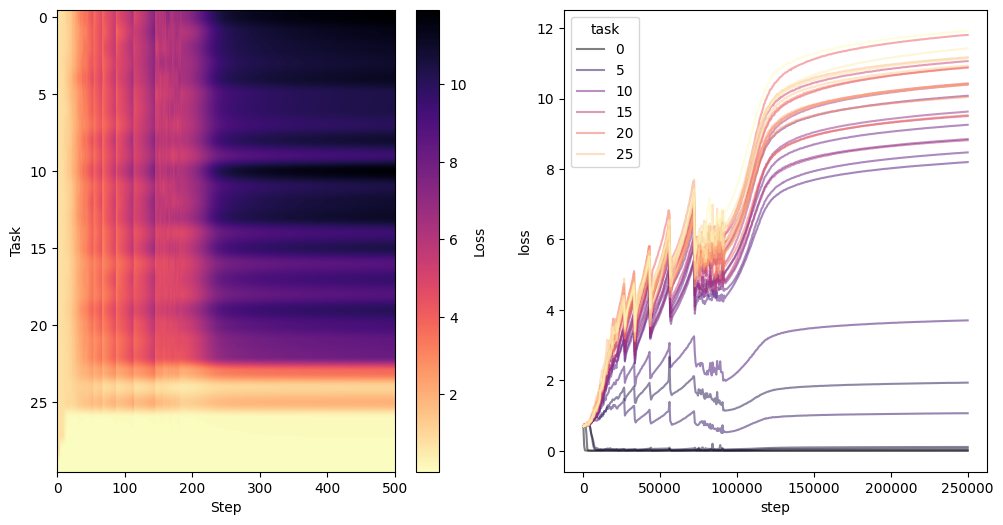

In [6]:
task_losses = df_rec["task_losses"].apply(pd.Series)
task_losses = task_losses.loc[:, sorted(task_losses.columns, reverse=True)]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes[0]
cax = ax.imshow(task_losses.transpose(), aspect="auto", cmap="magma_r")
ax.set_xlabel("Step")
ax.set_ylabel("Task")
fig.colorbar(cax, ax=ax, label="Loss")

ax = axes[1]
task_losses["step"] = df_rec["step"]
task_losses = task_losses.melt(id_vars="step", var_name="task", value_name="loss")
sns.lineplot(data=task_losses, x="step", y="loss", hue="task", ax=ax, palette="magma", alpha=0.5)

<Axes: xlabel='step', ylabel='error'>

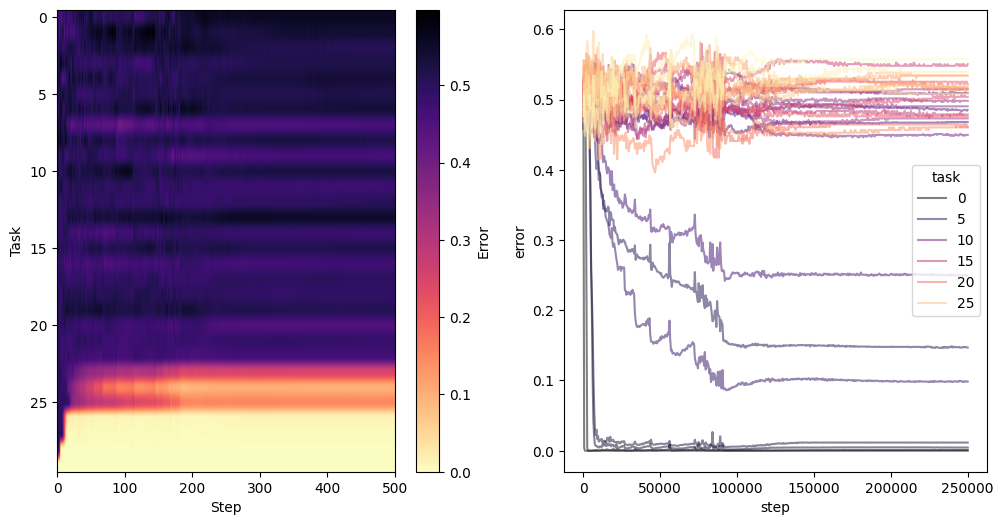

In [7]:
task_errors = df_rec["task_errors"].apply(pd.Series)
task_errors = task_errors.loc[:, sorted(task_errors.columns, reverse=True)]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes[0]
cax = ax.imshow(task_errors.transpose(), aspect="auto", cmap="magma_r")
ax.set_xlabel("Step")
ax.set_ylabel("Task")
fig.colorbar(cax, ax=ax, label="Error")

ax = axes[1]
task_errors["step"] = df_rec["step"]
task_errors = task_errors.melt(id_vars="step", var_name="task", value_name="error")
sns.lineplot(data=task_errors, x="step", y="error", hue="task", ax=ax, palette="magma", alpha=0.5)

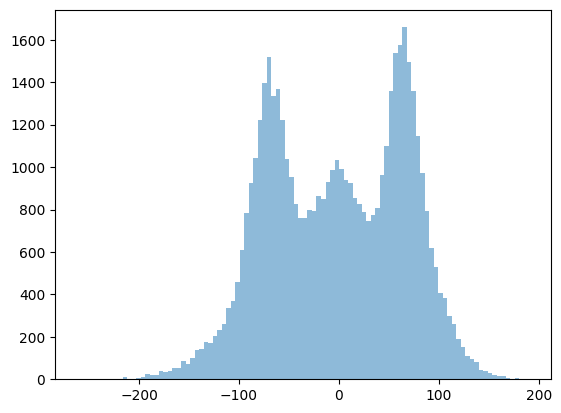

In [8]:
plt.hist(jax.vmap(model)(test_features).squeeze(), bins=100, alpha=0.5, label="Predictions");

# LLC and dLLC